# Intel / Nervana Systems Distiller Models

## AlexNet test

A deep look into the distiller, applied to pre-trained alexnet

Based on this notebook:

https://github.com/NervanaSystems/distiller/blob/master/jupyter/alexnet_insights.ipynb


For the notebook, we pruned Alexnet using sensitivity pruning and captured the checkpoints after the first epoch ends (epoch 0) and after the last epoch ends (epoch 89).

You can download these checkpoints from here:


https://s3-us-west-1.amazonaws.com/nndistiller/sensitivity-pruning/alexnet.checkpoint.0.pth.tar

https://s3-us-west-1.amazonaws.com/nndistiller/sensitivity-pruning/alexnet.checkpoint.89.pth.tar




In [1]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [15]:
import weightwatcher as ww
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

import torchvision.models as models


# Load some common jupyter code
%run './distiller_jupyter_helpers.ipynb'
from distiller.models import create_model
from distiller.apputils import *
import qgrid

from ipywidgets import *
from bqplot import *
import bqplot.pyplot as bqplt
from functools import partial

import powerlaw
from sklearn.decomposition import TruncatedSVD

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

marker_size = 75
plt.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams.update({'font.size': 20})
legend_prop={'size':16}



https://s3-us-west-1.amazonaws.com/nndistiller/sensitivity-pruning/alexnet.checkpoint.89.pth.tar

### From ModelZoo Notes;

Our reference is TorchVision's pretrained Alexnet model which has a Top1 accuracy of 56.55 and Top5=79.09. 

We prune away 88.44% of the parameters and achieve Top1=56.61 and Top5=79.45. 
 
#### But the pretrained model metadata has different results !

The checkpoint files give different top1 actual accuracies

#### Load Models

In [3]:
alexnet_baseline_model = models.alexnet(pretrained=True)

In [4]:
alexnet_epoch0 = create_model(False, 'imagenet', 'alexnet', parallel=True)
checkpoint_file = 'alexnet.checkpoint.0.pth.tar'
try:
    load_checkpoint(alexnet_epoch0, checkpoint_file)
except NameError as e:
    print("Did you forget to download the checkpoint file?")
    raise e
    

INFO:root:=> using alexnet model for ImageNet
INFO:root:=> loading checkpoint alexnet.checkpoint.0.pth.tar
INFO:root:=> Checkpoint contents:
╒═══════════════════╤═════════════╤═══════════════════╕
│ Key               │ Type        │ Value             │
╞═══════════════════╪═════════════╪═══════════════════╡
│ arch              │ str         │ alexnet           │
├───────────────────┼─────────────┼───────────────────┤
│ best_top1         │ float       │ 51.61572325080396 │
├───────────────────┼─────────────┼───────────────────┤
│ compression_sched │ dict        │                   │
├───────────────────┼─────────────┼───────────────────┤
│ epoch             │ int         │ 0                 │
├───────────────────┼─────────────┼───────────────────┤
│ optimizer         │ dict        │                   │
├───────────────────┼─────────────┼───────────────────┤
│ state_dict        │ OrderedDict │                   │
╘═══════════════════╧═════════════╧═══════════════════╛

INFO:root:Loaded c

In [5]:
alexnet_epoch89 = create_model(False, 'imagenet', 'alexnet', parallel=True)
checkpoint_file = 'alexnet.checkpoint.89.pth.tar'
try:
    load_checkpoint(alexnet_epoch89, checkpoint_file)
except NameError as e:
    print("Did you forget to download the checkpoint file?")
    raise e
    

INFO:root:=> using alexnet model for ImageNet
INFO:root:=> loading checkpoint alexnet.checkpoint.89.pth.tar
INFO:root:=> Checkpoint contents:
╒═══════════════════╤═════════════╤═══════════════════╕
│ Key               │ Type        │ Value             │
╞═══════════════════╪═════════════╪═══════════════════╡
│ arch              │ str         │ alexnet           │
├───────────────────┼─────────────┼───────────────────┤
│ best_top1         │ float       │ 52.04268007118549 │
├───────────────────┼─────────────┼───────────────────┤
│ compression_sched │ dict        │                   │
├───────────────────┼─────────────┼───────────────────┤
│ epoch             │ int         │ 89                │
├───────────────────┼─────────────┼───────────────────┤
│ optimizer         │ dict        │                   │
├───────────────────┼─────────────┼───────────────────┤
│ state_dict        │ OrderedDict │                   │
╘═══════════════════╧═════════════╧═══════════════════╛

INFO:root:Loaded 

### Test Accuracy vs Norm Metrics

In [6]:
models_dict = {'Epoch 0': alexnet_epoch0, 
               'Epoch 89': alexnet_epoch89}

In [7]:
# From https://nervanasystems.github.io/distiller/model_zoo/index.html
top5 = {
    'Epoch 0': 56.55,
    'Epoch 89': 56.61, 
}

top1 =  {
    'Epoch 0': 79.09,
    'Epoch 89': 79.45,
}

# actual in checkpoint files

top1_actuals =  {
    'Epoch 0': 51.65,
    'Epoch 89': 52.04,
}

In [8]:
results = {}
for modelname, model in models_dict.items():
    watcher = ww.WeightWatcher(model=model, logger=logger)
    watcher.analyze(compute_alphas=True)
    results[modelname] = watcher.get_summary()

INFO:app_cfg:
WeightWatcher v0.1.2 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.15.3
tensforflow version 1.10.1
keras       version 2.2.2
INFO:app_cfg:Analyzing model
INFO:app_cfg:### Printing results ###
INFO:app_cfg:LogNorm: min: 0.5002315640449524, max: 1.7227274179458618, avg: 0.838710606098175
INFO:app_cfg:LogNorm compound: min: 0.6641425275802613, max: 1.7227274179458618, avg: 1.191542415164766
INFO:app_cfg:Alpha: min: 1.5591811901537644, max: 4.709374208477201, avg: 2.765781599400109
INFO:app_cfg:Alpha compound: min: 2.3017986173415443, max: 3.838625092395437, avg: 2.823852218168507
INFO:app_cfg:Alpha Weighted: min: -0.20160361115319728, max: 4.844621782183818, avg: 1.6620989747223358
INFO:app_cfg:Alpha Weighted compound: min: 0.9073365922042744, max: 4.844621

### Compare summaries - nothing really surprising

$\alpha$ is the same, $\log\Vert\mathbf{W}\Vert^{2}$ is smaller

$\hat\alpha$ is smaller, because the spectral norm $\lambda_{max}$ is smaller

In [9]:
results

{'Epoch 0': {'lognorm': 0.8387106,
  'lognorm_compound': 1.191542415164766,
  'alpha': 2.765781599400109,
  'alpha_compound': 2.823852218168507,
  'alpha_weighted': 1.6620989747223358,
  'alpha_weighted_compound': 2.7949505129168437},
 'Epoch 89': {'lognorm': 0.81952375,
  'lognorm_compound': 1.1409434475406768,
  'alpha': 2.804121037461088,
  'alpha_compound': 2.9581156677441918,
  'alpha_weighted': 1.5100703664314679,
  'alpha_weighted_compound': 2.469589313658936}}

### Details of  FC Layers

How could the average alpha be so off ?

In [10]:
def randomize_mat(W):
    Wshape = W.shape
    Wrand = W.flatten()
    np.random.shuffle(Wrand)
    Wrand = Wrand.reshape(Wshape)
    return Wrand

 Linear(in_features=9216, out_features=4096, bias=True)
----------
 AlexNet 0
----------


Calculating best minimal value for power law fit
Assuming nested distributions


alpha w/xmax  2.3923799707613655
truncated alpha ?  (-0.2819218428675816, 0.45271569551582735)
alpha log xmax  3.37107366026294
norm W  52.81137
actual vs random  25.650028 8.546239 0.33318633
----------
 AlexNet 89
----------


Calculating best minimal value for power law fit
Assuming nested distributions


alpha w/xmax  2.6480304050303776
truncated alpha ?  (-0.14183590009717084, 0.5943046260863423)
alpha log xmax  2.7132828298730014
norm W  36.18648
actual vs random  10.583807 1.9784461 0.18693143


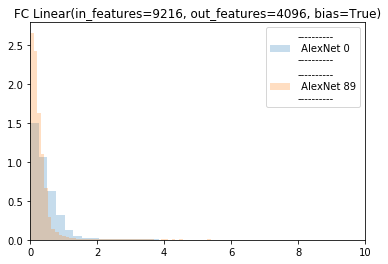

 Linear(in_features=4096, out_features=4096, bias=True)
----------
 AlexNet 0
----------


Calculating best minimal value for power law fit
Assuming nested distributions


alpha w/xmax  2.3648252565364434
truncated alpha ?  (-0.6694298704182451, 0.24723515533210938)
alpha log xmax  4.182282479559077
norm W  44.89684
actual vs random  58.686424 26.956299 0.45932767
----------
 AlexNet 89
----------


Calculating best minimal value for power law fit
Assuming nested distributions


alpha w/xmax  2.7090875502478906
truncated alpha ?  (-0.2638991016083726, 0.4675340142674306)
alpha log xmax  3.5446102909055046
norm W  34.883392
actual vs random  20.342993 7.905049 0.38858828


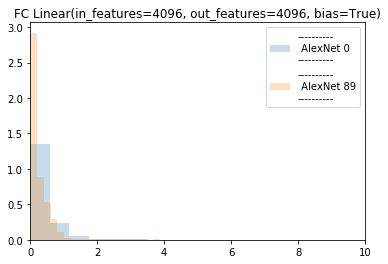

 Linear(in_features=4096, out_features=1000, bias=True)
----------
 AlexNet 0
----------


Calculating best minimal value for power law fit
Assuming nested distributions


alpha w/xmax  3.069478885563382
truncated alpha ?  (5.9491305277447476e-08, 0.9997247788535687)
alpha log xmax  4.844623654793567
norm W  37.205166
actual vs random  37.87226 3.0902987 0.08159795
----------
 AlexNet 89
----------


Calculating best minimal value for power law fit
Assuming nested distributions


alpha w/xmax  3.3625921617051837
truncated alpha ?  (8.865468191518802e-07, 0.9989375566832741)
alpha log xmax  4.5449939798882495
norm W  34.7685
actual vs random  22.471603 2.7035375 0.12030906


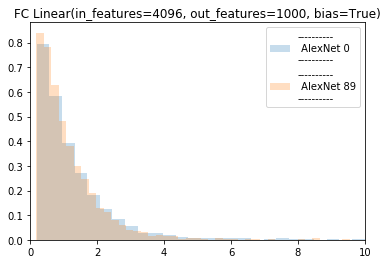

In [11]:
layers0  = alexnet_epoch0.modules()
layers89 = alexnet_epoch89.modules()

for l0, l89 in zip(layers0, layers89):
    if (type(l0)==torch.nn.modules.linear.Linear):
        print("==========\n",l0)
        for i,l in enumerate([l0, l89]):
                         
            label = "----------\n AlexNet {}\n----------".format(i*89)
            print(label)
            W = [np.array(l.weight.data.clone().cpu())][0]
            N, M = np.max(W.shape), np.min(W.shape)
      
            svd = TruncatedSVD(n_components=M-1)        
            svd.fit(W)

            sv = svd.singular_values_
            ev = sv*sv
            max_ev =  np.max(ev)

            plt.hist(ev, bins=100, density=True, alpha=0.25, label=label);
       
            fit = powerlaw.Fit(ev, xmax=max_ev)
            randP = fit.loglikelihood_ratio('power_law', 'truncated_power_law')
            print("alpha w/xmax ", fit.alpha)
            print("truncated alpha ? ", randP)
            print("alpha log xmax ", fit.alpha*np.log10(max_ev))

           # print("truncated alpha ", fit.truncated_power_law.alpha, randP)
    
            svdR = TruncatedSVD(n_components=M-1)
            svdR.fit(randomize_mat(W))
            sv = svdR.singular_values_
            ev = sv*sv
            max_rand_ev =  np.max(ev)
            
            print("norm W ", np.linalg.norm(W))
            print("actual vs random ", max_ev, max_rand_ev, max_rand_ev/max_ev )

        plt.legend()
        plt.xlim([0,10])
        plt.title("FC {}".format(l))
        plt.show()

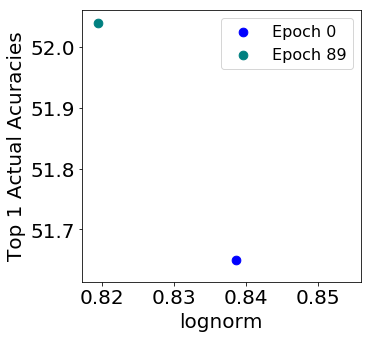

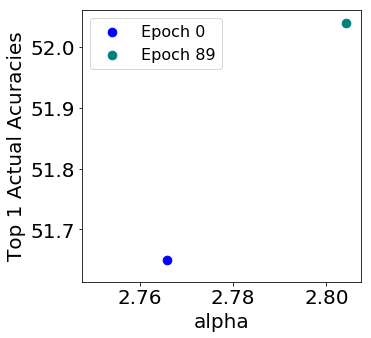

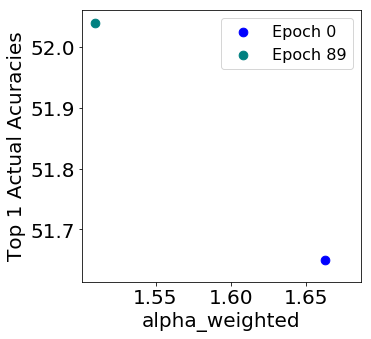

In [16]:

metrics = ['lognorm', 'alpha', 'alpha_weighted'] 
colors = ['blue', 'cyan']

for metric in metrics:
  
    plt.scatter(results['Epoch 0'][metric], top1_actuals['Epoch 0'], label='Epoch 0', s=marker_size, color='blue');
    plt.scatter(results['Epoch 89'][metric], top1_actuals['Epoch 89'], label='Epoch 89', s=marker_size, color='teal');

    plt.xlabel(metric)
    plt.ylabel("Top 1 Actual Acuracies")
    plt.legend(prop=legend_prop)
    plt.show();
           
           

## Additional AlexNet Models

In [18]:
!wget https://s3-us-west-1.amazonaws.com/nndistiller/hybrid/checkpoint.alexnet.schedule_sensitivity_2D-reg.pth.tar

--2019-04-17 18:47:19--  https://s3-us-west-1.amazonaws.com/nndistiller/hybrid/checkpoint.alexnet.schedule_sensitivity_2D-reg.pth.tar
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.28.17
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.28.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 733174965 (699M) [application/x-tar]
Saving to: ‘checkpoint.alexnet.schedule_sensitivity_2D-reg.pth.tar’

checkpoint.alexnet. 100%[===================>] 699.21M  10.7MB/s    in 69s     

2019-04-17 18:48:28 (10.1 MB/s) - ‘checkpoint.alexnet.schedule_sensitivity_2D-reg.pth.tar’ saved [733174965/733174965]



In [20]:
alexnet_s2D = create_model(False, 'imagenet', 'alexnet', parallel=True)
checkpoint_file = 'checkpoint.alexnet.schedule_sensitivity_2D-reg.pth.tar'
try:
    load_checkpoint(alexnet_s2D, checkpoint_file)
except NameError as e:
    print("Did you forget to download the checkpoint file?")
    raise e

INFO:root:=> using alexnet model for ImageNet
INFO:root:=> loading checkpoint checkpoint.alexnet.schedule_sensitivity_2D-reg.pth.tar
INFO:root:=> Checkpoint contents:
╒═══════════════════╤═════════════╤══════════════════╕
│ Key               │ Type        │ Value            │
╞═══════════════════╪═════════════╪══════════════════╡
│ arch              │ str         │ alexnet          │
├───────────────────┼─────────────┼──────────────────┤
│ best_top1         │ float       │ 51.8389584439102 │
├───────────────────┼─────────────┼──────────────────┤
│ compression_sched │ dict        │                  │
├───────────────────┼─────────────┼──────────────────┤
│ epoch             │ int         │ 89               │
├───────────────────┼─────────────┼──────────────────┤
│ optimizer         │ dict        │                  │
├───────────────────┼─────────────┼──────────────────┤
│ state_dict        │ OrderedDict │                  │
╘═══════════════════╧═════════════╧══════════════════╛

INFO:ro

In [29]:
top1_actuals['alexnet_s2D']=51.84

In [22]:
watcher = ww.WeightWatcher(model=alexnet_s2D, logger=logger)
watcher.analyze(compute_alphas=True)
results["alexnet_s2D"] = watcher.get_summary()

INFO:app_cfg:
WeightWatcher v0.1.2 by Calculation Consulting
Analyze weight matrices of Deep Neural Networks
https://calculationconsulting.com/
python      version 3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy       version 1.15.3
tensforflow version 1.10.1
keras       version 2.2.2
INFO:app_cfg:Analyzing model
INFO:app_cfg:### Printing results ###
INFO:app_cfg:LogNorm: min: 0.4079688787460327, max: 1.5691872835159302, avg: 0.7604209184646606
INFO:app_cfg:LogNorm compound: min: 0.619149100780487, max: 1.5691872835159302, avg: 1.1014356743721734
INFO:app_cfg:Alpha: min: 1.4929209292008019, max: 4.721652646667204, avg: 2.8349222985802065
INFO:app_cfg:Alpha compound: min: 2.4049861254156397, max: 3.914607263853011, avg: 2.9625064495159648
INFO:app_cfg:Alpha Weighted: min: -0.7576261594241995, max: 4.678854743873357, avg: 1.0651824230355829
INFO:app_cfg:Alpha Weighted compound: min: 0.6690242052535627, max: 4.6788

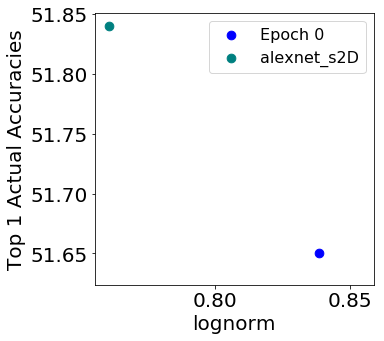

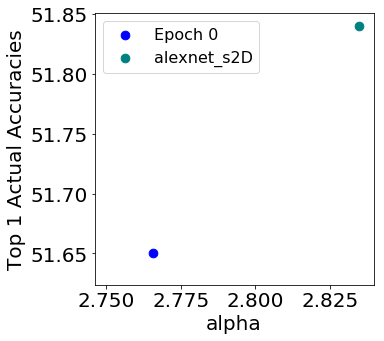

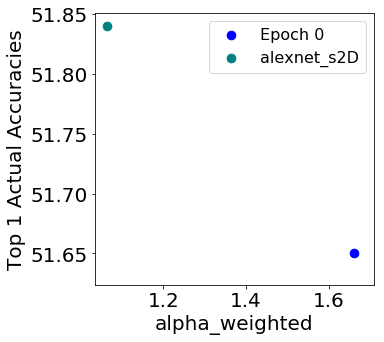

In [33]:

metrics = ['lognorm', 'alpha', 'alpha_weighted'] 
colors = ['blue', 'cyan']

for metric in metrics:
  
    plt.scatter(results['Epoch 0'][metric], top1_actuals['Epoch 0'], label='Epoch 0', s=marker_size, color='blue');
    plt.scatter(results['alexnet_s2D'][metric], top1_actuals['alexnet_s2D'], label='alexnet_s2D', s=marker_size, color='teal');

    plt.xlabel(metric)
    plt.ylabel("Top 1 Actual Accuracies")
    plt.legend(prop=legend_prop)
    plt.show();

{'lognorm': 0.8387106,
 'lognorm_compound': 1.191542415164766,
 'alpha': 2.765781599400109,
 'alpha_compound': 2.823852218168507,
 'alpha_weighted': 1.6620989747223358,
 'alpha_weighted_compound': 2.7949505129168437}